In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision.transforms import Compose, ToTensor
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
###-- INPUTS --###



In [3]:
class ImagesDataset(Dataset):

    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        self.root = root + "/Images"
        self.labels_path = root + "/labels.txt"
        self.images_path = root + "/Images"
        self.transform = transform

        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels

        Helper method for the constructor
        """
        with open(self.labels_path) as f:
            imu_list = f.readlines()

        imu_list = [float(s.strip()) for s in imu_list]
        image_list = [x for x in os.listdir(self.root)]

        if (len(imu_list) != len(image_list)):
            raise TypeError("IMU data and image data have different sizes.")

        datalist = []
        for i in range(len(imu_list)):
            datalist.append([self.images_path + "/" + image_list[i], imu_list[i]])

        return datalist

    @staticmethod
    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.

        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

In [4]:
def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """

    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")

    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)

In [5]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of DogsCatsData datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.

    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)

    Args:
        transformations (list(DogsCatsData)): list of dataset instances with different transformations
        index (int): Index of the sample in the dataset you wish to compare.
    """

    # Here we combine two functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, e.g. a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError("All elements in the `transformations` list need to be of type Dataset")

    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)

    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title(f"transf: {counter}")
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

In [6]:
def generate_dataloader(dataset, batch_size, props = [0.8, 0.1, 0.1]):


    lengths = [int(p * len(dataset)) for p in props]
    lengths[-1] = len(dataset) - sum(lengths[:-1])
    train_set, val_set, test_set = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size, shuffle=False)
    test_loader = DataLoader(test_set)

    return train_loader, val_loader, test_loader

In [7]:
def generate_transforms(image_path):

    # TRANSFORMS
    transform_random = transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    transform_center = transforms.Compose([
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    transform_resize_greyscale_normalize = transforms.Compose([
        transforms.Resize((64, 64)),
        #transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    all_transforms = [ImagesDataset(image_path, transform_resize_greyscale_normalize),
                      ImagesDataset(image_path, transform_random), ImagesDataset(image_path, transform_center),
                      ImagesDataset(image_path, Compose([ToTensor()]))]
    no_transform = ImagesDataset(image_path, Compose([ToTensor()]))

    return all_transforms, no_transform, transform_resize_greyscale_normalize

In [8]:
def plot_metrics(fig, ax, train_losses, val_losses):

    # Plot losses
    '''
    fig.clear()
    fig.plot(train_losses)
    fig.plot(val_losses)
    fig.set_title('Loss')
    fig.legend(['Train','Validation'])
    fig.set_xlabel('Number of trained batches')
    fig.grid()
    fig.plot([1.5]*5, 'k--')
    '''
    
    ax[0].clear()
    ax[0].plot(train_losses)
    ax[0].plot(val_losses)
    ax[0].set_title('Loss')
    ax[0].legend(['Train','Validation'])
    ax[0].set_xlabel('Number of trained batches')
    ax[0].grid()
    ax[0].plot([1.5]*epochs, 'k--')

    
    fig.canvas.draw()


In [9]:
class LinearModel(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()

        if dataset.__getitem__(0)[0].dim() == 3:
            h, w = (dataset.__getitem__(0)[0]).size()[1], (dataset.__getitem__(0)[0]).size()[2]

        self.layer1 = nn.Linear(in_features=h*w*3, out_features= 1) ##CHANGE THIS 
        self.loss_fn = nn.L1Loss()

    def forward(self, x):
        x = x.flatten(1,3)
        a1 = self.layer1(x)
        o = a1

        return o


In [23]:
def conv_shape(x, k=1, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1) # helper function to have to generalize Linear layer in a CNN. Recursion needs to be implemented.

class CNN(torch.nn.Module):
    def __init__(self, channel_size = 3, kernel_size = 3, filter_size = 10, stride = 1, maxpool_size = 2):
        super().__init__()

        self.loss_fn = nn.L1Loss()

        img_size = 64
        last_filter_size = 10
        padding_size = 0
        #f = lambda input_size: (input_size - kernel_size + 2 * padding_size) / stride + 1
        
        self.conv1 = nn.Conv2d(channel_size, filter_size, kernel_size, stride)
        self.conv2 = nn.Conv2d(filter_size, filter_size, kernel_size, stride)
        self.pool = nn.MaxPool2d(maxpool_size, maxpool_size)

        O_size = int((img_size - kernel_size + 2*padding_size)/stride + 1) # Conv2d layer output
        #a = int(((f(f(img_size))/maxpool_size)**2)*filter_size)
        #self.output = nn.Linear(O_size, 1)


    def forward(self, x):
        o = self.conv1(x)
        o = F.relu(o)
        o = self.conv2(o)
        o = F.relu(o)
        o = self.pool(o)
        o = torch.flatten(o)
        out_layer = nn.Linear(o.size(dim=0), 1)
        
        
        o = out_layer(o)
        return o

In [24]:
def train(val_freq, train_loader, model, optimizer, val_loader, plotwhile = True):
    %matplotlib notebook
    fig, ax = plt.subplots(ncols=2, figsize=(12,4))
    train_losses = []
    val_losses = []
    for epoch in range(int(epochs)):
        print("===================")
        print("Epoch {} out of {}.".format(epoch, epochs))
        running_loss = 0
        iter = 0
        for i, (inputs, labels) in enumerate(train_loader):
            #inputs = inputs.flatten(2,3)
            labels = torch.unsqueeze(labels, 0)
            optimizer.zero_grad()
            preds = model.forward(inputs)
            loss = model.loss_fn(preds, torch.transpose(labels, 0, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            iter += 1
            if iter % val_freq == 0:
                total_mae = 0
                s = 0
                for inputs, labels in val_loader:
                    #inputs = inputs.flatten(2,3)
                    preds = model.forward(inputs)
                    labels = torch.unsqueeze(labels, 0)
                    mae = model.loss_fn(preds, torch.transpose(labels, 0, 1))
                    total_mae += mae
                    s += 1

                iter_mae = total_mae/s
                print("Iteration: {}. train_loss: {}. val_loss: {}.".format(iter, loss.item(), iter_mae))

                train_losses.append(loss.item())
                val_losses.append(iter_mae.item())
                if plotwhile:
                    plot_metrics(fig, ax, train_losses, val_losses)
    return train_losses, val_losses

<IPython.core.display.Javascript object>


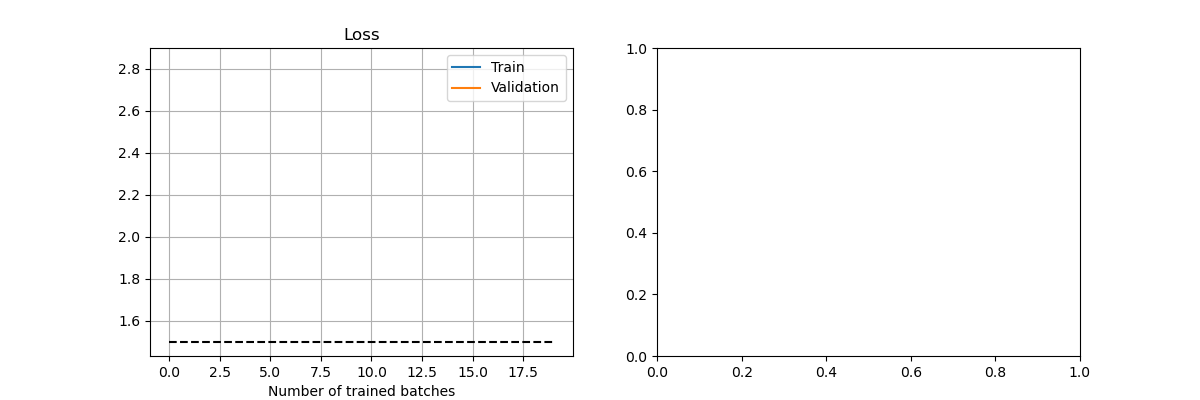

Epoch 0 out of 20.
Iteration: 5. train_loss: 2.831770896911621. val_loss: 2.6567506790161133.


KeyboardInterrupt: 

In [33]:
batch_size = 32
img_size = 64
step_size = 10
gamma = 0.5
epochs = 20
print_freq = 1

image_path = './Train'
all_transforms, no_transform, transform_resize_greyscale_normalize = generate_transforms(image_path)
dataset = ImagesDataset(image_path, transform_resize_greyscale_normalize)
train_loader, val_loader, test_loader = generate_dataloader(dataset, batch_size, [.8, .1, .1])

#TRAIN
#model = LinearModel(dataset)
model = CNN()
optim = torch.optim.SGD(model.parameters(), lr = 0.0005)
train_losses, val_losses = train(5, train_loader, model, optim, val_loader)


In [34]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv1.weight tensor([[[[ 0.0126, -0.1268,  0.0372],
          [-0.1217,  0.1434,  0.0677],
          [-0.1012, -0.0852, -0.1392]],

         [[-0.1221, -0.1114,  0.1583],
          [ 0.1646,  0.1506, -0.0875],
          [-0.0133,  0.0102,  0.1817]],

         [[ 0.0495, -0.1578, -0.1366],
          [ 0.0226, -0.0294, -0.0763],
          [-0.0556, -0.1164,  0.0491]]],


        [[[ 0.1921, -0.0403,  0.1221],
          [ 0.0861,  0.0631, -0.1708],
          [-0.0537,  0.1161, -0.0966]],

         [[-0.0983, -0.1030, -0.0668],
          [ 0.0328,  0.0995,  0.1277],
          [ 0.1167,  0.0101,  0.0304]],

         [[ 0.1591,  0.1238, -0.0396],
          [ 0.1676,  0.0924,  0.1412],
          [-0.0609, -0.0264, -0.0960]]],


        [[[-0.1072, -0.1296,  0.1688],
          [-0.0154, -0.1766, -0.0948],
          [-0.0842, -0.1275,  0.1729]],

         [[-0.1273, -0.0612, -0.1756],
          [ 0.1193, -0.0052, -0.0378],
          [ 0.0451,  0.0694, -0.1321]],

         [[-0.0015,  0.0786, -0